## Notebook 02 - Generación de conjuntos train/test (walk-forward)

Este notebook implementa una división de datos tipo walk-forward, para respetar la naturaleza temporal de las series. Se construyen conjuntos de entrenamiento y validación en bloques sucesivos y se aplican transformaciones como codificación y escalado.

In [1]:
# cargar librerias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
#import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from datetime import datetime
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from itertools import product


In [2]:
# cargar dataset
df = pd.read_csv('../dataset/final.csv')
df.shape

(1835, 51)

In [3]:
df.head(-5)

,time,T.obs,Hr.obs,pr.obs,Rad.obs,u.obs,u_gr.obs,Td.obs,EPenman.obs,pp_obs,...,VientoI,T_sup,CondsupC,MicrtEli,EscColi,PROFSITI,SatSupC,pHsupC,Secc_sup,target
0,2020-02-14,26.145833,84.125000,1004.545833,117.666667,3.451042,207.500000,23.116667,0.056250,8.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
1,2020-02-15,26.241667,82.708333,1004.579167,287.812500,2.844792,183.614583,22.945833,0.083750,0.0,...,11.387102,27.859369,69.994823,0.150000,297.000000,1.000000,78.600000,8.558289,0.331457,3.0
2,2020-02-16,26.737500,87.666667,1003.220833,202.822917,3.078125,169.270833,24.454167,0.062083,8.0,...,11.817892,27.686359,69.621235,0.150000,297.000000,1.000000,78.600000,8.461255,0.337650,3.0
3,2020-02-17,26.000000,85.875000,1000.762500,149.968750,5.366667,167.343750,23.400000,0.064583,7.0,...,12.376893,27.497214,69.218023,0.150000,297.000000,1.000000,78.600000,8.345347,0.343829,1.0
4,2020-02-18,22.666667,76.625000,1004.875000,264.114583,2.745833,161.000000,17.758333,0.085000,9.0,...,13.000000,27.300000,68.800000,2.130000,297.000000,1.000000,90.100000,8.220000,0.350000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,2025-02-12,23.662500,86.000000,1006.012500,92.385417,7.408333,105.354167,21.129167,0.058750,0.0,...,9.325751,29.903977,68.115822,0.158055,80.000000,1.028339,112.742619,8.845731,0.705321,1.0
1826,2025-02-13,26.550000,76.250000,1009.245833,283.916667,5.185417,109.718750,21.716667,0.117917,0.0,...,9.329573,29.464381,67.274135,0.163660,80.000000,1.028799,104.518731,8.682256,0.745190,1.0
1827,2025-02-14,28.779167,68.291667,1006.054167,259.770833,1.685417,100.677083,21.975000,0.087917,0.0,...,8.692789,29.029703,66.589283,0.170055,78.131337,1.043591,102.200000,8.526492,0.742932,1.0
1828,2025-02-15,24.020833,86.208333,1003.812500,80.583333,3.082292,123.791667,21.462500,0.042917,0.0,...,7.592561,28.624426,66.053693,0.177041,74.620882,1.065320,102.200000,8.384893,0.705284,1.0


Conteo de clases en la variable objetivo:
target
0.0    1558
1.0     125
3.0     114
2.0      38
Name: count, dtype: int64

Porcentaje de cada clase:
target
0.0    84.90
1.0     6.81
3.0     6.21
2.0     2.07
Name: proportion, dtype: float64 %


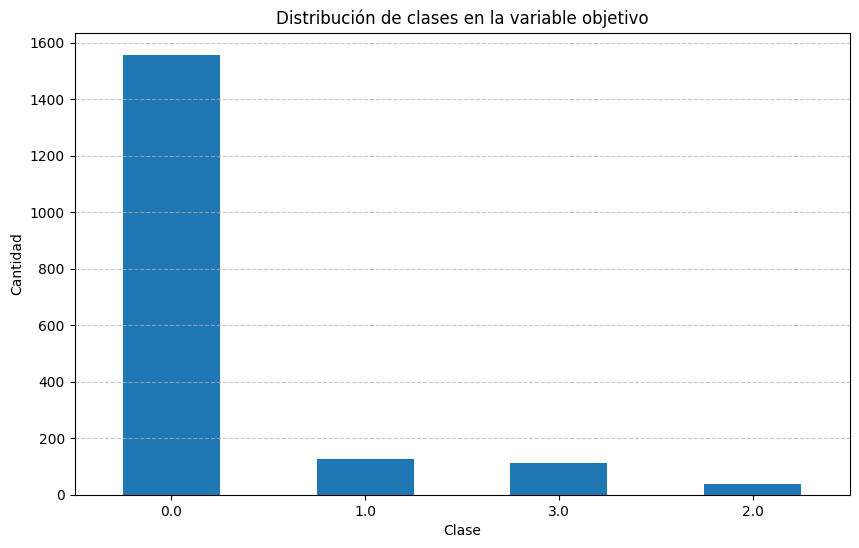

In [14]:
# Conteo de valores en la columna target
target_counts = df['target'].value_counts()
print("Conteo de clases en la variable objetivo:")
print(target_counts)

# Mostrar porcentajes
target_percentages = df['target'].value_counts(normalize=True) * 100
print("\nPorcentaje de cada clase:")
print(target_percentages.round(2), "%")

# Visualización
plt.figure(figsize=(10, 6))
target_counts.plot(kind='bar')
plt.title('Distribución de clases en la variable objetivo')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
num_duplicados = df['time'].duplicated().sum()
print("Cantidad de duplicados en 'time':", num_duplicados)

Cantidad de duplicados en 'time': 0


# Split Train Test

In [16]:
df = df.sort_values('time').reset_index(drop=True)
df['time'] = pd.to_datetime(df['time'])
ultimo_dia = df['time'].max()

# Definir ventanas
test_start = ultimo_dia - pd.Timedelta(days=29)
val_end = test_start - pd.Timedelta(days=1)
val_start = val_end - pd.Timedelta(days=59)
print(ultimo_dia)
print(test_start)
print(val_end)
print(val_start)

df_test = df[df['time'] >= test_start].copy()
df_val = df[(df['time'] >= val_start) & (df['time'] <= val_end)].copy()
df_train = df[df['time'] < val_start].copy()
df_train_val = pd.concat([df_train, df_val])

print(df_test.shape)
print(df_val.shape)
print(df_train.shape)
print(df_train_val.shape)

2025-02-21 00:00:00
2025-01-23 00:00:00
2025-01-22 00:00:00
2024-11-24 00:00:00
(30, 51)
(60, 51)
(1745, 51)
(1805, 51)


## Técnica Walk-Forward Cross Validation (WFCV) RANDOMFOREST

In [7]:


def add_time_int(df, time_col='time'):
    """Agrega columna time_int tomando 01-01-1900 como referencia."""
    base = datetime(1900, 1, 1)
    df['time_int'] = (df[time_col] - base).dt.days + 1
    return df

def walkforward_grid_search_rf(
    df, 
    target_col='target', 
    time_col='time', 
    val_start='2024-11-24', 
    val_end='2025-01-22', 
    param_grid=None
):
    """
    Grid search de RandomForest con walk-forward sobre la ventana de validación.
    """
    # Asegurar formato datetime
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df = add_time_int(df, time_col)
    
    # Features a usar (excluyendo time y target)
    feature_cols = [col for col in df.columns if col not in [time_col, target_col]]
    
    # Generar lista de días de validación
    val_days = pd.date_range(val_start, val_end)
    
    # Generar todas las combinaciones de hiperparámetros
    if param_grid is None:
        param_grid = {
            'n_estimators': [50, 100, 200, 300, 400],
            'max_depth': [2, 3, 5, 10, None],
            'min_samples_split': [2, 3, 5],
            'min_samples_leaf': [1, 2, 3],
            #'max_features': ['sqrt', 'log2', None]
        }
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]
    
    best_score = -1
    best_params = None
    all_results = []
    
    print(f"Probando {len(param_combinations)} combinaciones de hiperparámetros...")
    for params in tqdm(param_combinations):
        preds = []
        trues = []
        for val_day in val_days:
            train_idx = df[time_col] < val_day
            val_idx = df[time_col] == val_day
            if val_idx.sum() == 0 or train_idx.sum() == 0:
                continue  # Saltar si no hay datos para ese día

            X_train = df.loc[train_idx, feature_cols]
            y_train = df.loc[train_idx, target_col]
            X_val = df.loc[val_idx, feature_cols]
            y_val = df.loc[val_idx, target_col]
            
            # Entrenar y predecir
            clf = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            preds.extend(y_pred)
            trues.extend(y_val)
        
        acc = accuracy_score(trues, preds)
        all_results.append({'params': params, 'accuracy': acc})
        if acc > best_score:
            best_score = acc
            best_params = params
    print("\nResultados del grid search:")
    print(all_results)

    print(f"Mejores hiperparámetros: {best_params}")
    print(f"Exactitud en validación: {best_score:.4f}")
    return best_params, best_score, all_results

best_params, best_score, all_results = walkforward_grid_search_rf(df_train_val)


Probando 225 combinaciones de hiperparámetros...


100%|██████████| 225/225 [58:05<00:00, 15.49s/it]


Resultados del grid search:
[{'params': {'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1}, 'accuracy': 0.8666666666666667}, {'params': {'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 2}, 'accuracy': 0.8666666666666667}, {'params': {'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 3}, 'accuracy': 0.8666666666666667}, {'params': {'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 1}, 'accuracy': 0.8666666666666667}, {'params': {'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 2}, 'accuracy': 0.8666666666666667}, {'params': {'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 3}, 'accuracy': 0.8666666666666667}, {'params': {'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 1}, 'accuracy': 0.8666666666666667}, {'params': {'n_estimators': 50, 'max_depth': 2, 'min_samples_split'

# RamdomForest Test con retorno de importancia de atributos

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from datetime import datetime

def walkforward_test_rf_importance(
    df, 
    best_params, 
    target_col='target', 
    time_col='time', 
    test_start='2025-01-23', 
    test_end='2025-02-21'
):
    """
    Test walk-forward sobre la ventana de test usando los mejores hiperparámetros.
    Imprime exactitud y matriz de confusión.
    Recolecta y retorna la importancia de atributos para cada día de entrenamiento.
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    if 'time_int' not in df.columns:
        base = datetime(1900, 1, 1)
        df['time_int'] = (df[time_col] - base).dt.days + 1
    
    feature_cols = [col for col in df.columns if col not in [time_col, target_col]]
    test_days = pd.date_range(test_start, test_end)
    preds = []
    trues = []
    
    # DataFrame para almacenar la importancia de los atributos
    feature_importance_df = pd.DataFrame()
    
    for test_day in tqdm(test_days, desc="Walk-forward test"):
        train_idx = df[time_col] < test_day
        test_idx = df[time_col] == test_day
        if test_idx.sum() == 0 or train_idx.sum() == 0:
            continue
        X_train = df.loc[train_idx, feature_cols]
        y_train = df.loc[train_idx, target_col]
        X_test = df.loc[test_idx, feature_cols]
        y_test = df.loc[test_idx, target_col]
        clf = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        preds.extend(y_pred)
        trues.extend(y_test)
        
        # Guardar importancia de atributos para este día
        importances = clf.feature_importances_
        # Crear un DataFrame temporal con las importancias
        temp_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': importances,
            'test_day': test_day
        })
        # Ordenar por importancia descendente
        temp_df = temp_df.sort_values('importance', ascending=False).reset_index(drop=True)
        # Añadir ranking
        temp_df['rank'] = temp_df.index + 1
        # Concatenar al DataFrame principal
        feature_importance_df = pd.concat([feature_importance_df, temp_df], ignore_index=True)
    
    # Calcular métricas
    acc = accuracy_score(trues, preds)
    print(f"Exactitud en test: {acc:.4f}")
 
    labels = [0, 1, 2, 3]
    cm = confusion_matrix(trues, preds, labels=labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm_normalized, 
        annot=cm,            # <--- aquí pones los valores reales
        fmt='d',             # formato entero
        cmap="Blues", 
        xticklabels=labels, 
        yticklabels=labels,
        cbar=True
    )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Matriz de confusión RF')
    plt.show()


    # F1-score macro (promedio igual para cada clase)
    # También puedes usar 'weighted', 'micro', o calcular por clase con average=None
    f1 = f1_score(trues, preds, average='macro')
    print(f"F1-score (macro): {f1:.4f}")
    
    # Visualizar la importancia promedio de los atributos
    avg_importance = feature_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    avg_importance.plot(kind='bar')
    plt.title('Importancia promedio de atributos en todas las iteraciones')
    plt.ylabel('Importancia')
    plt.tight_layout()
    plt.show()
    
    return preds, trues, acc, cm, feature_importance_df

# ACA HIPER DEL RF

Walk-forward test: 100%|██████████| 30/30 [00:06<00:00,  4.59it/s]

Exactitud en test: 0.9333



C:\Users\tschoppj\AppData\Local\Temp\ipykernel_42892\599678536.py:72: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


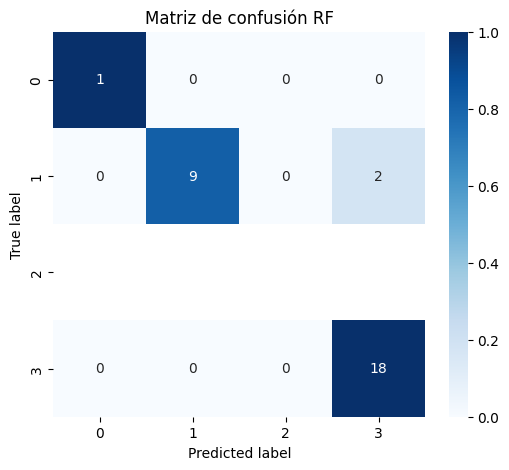

F1-score (macro): 0.9491


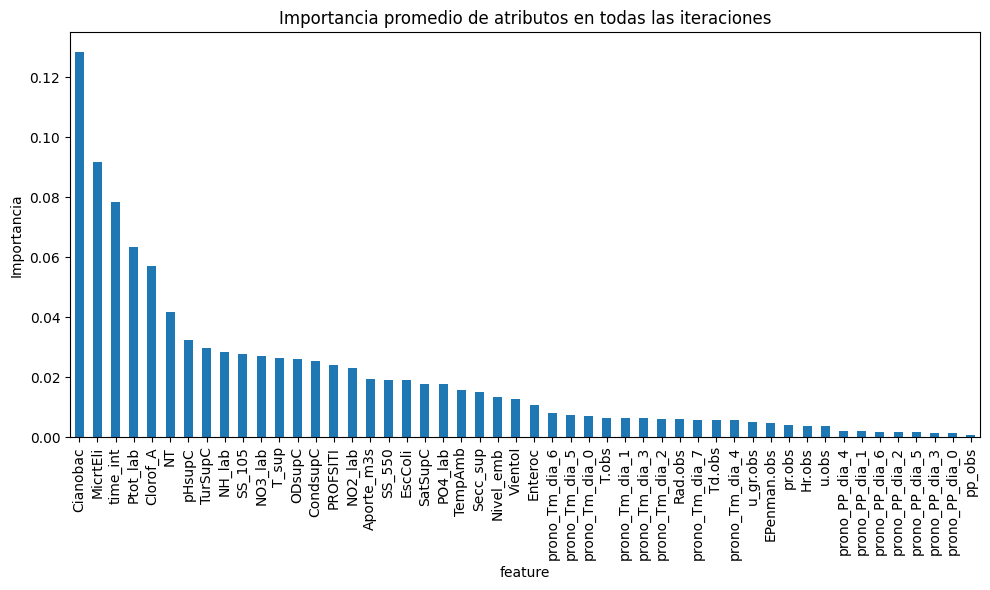

In [10]:
#Resultados del grid search:
# 
#Mejores hiperparámetros: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}
#Exactitud en validación: 0.9167
import seaborn as sns


preds, trues, acc, cm, df_rf_importance = walkforward_test_rf_importance(
    df, 
    best_params={'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}, 
    target_col='target', 
    time_col='time', 
    test_start='2025-01-23', 
    test_end='2025-02-21'
)

In [11]:
print(df_rf_importance.head(10))

# Filtrar variables con importancia promedio > 0.02
avg_importance = df_rf_importance.groupby('feature')['importance'].mean().sort_values(ascending=False)
important_vars = avg_importance[avg_importance > 0.02].index.tolist()

# Asegurar que Clorof_A y Cianobac estén incluidas
if 'Clorof_A' not in important_vars:
    important_vars.append('Clorof_A')
if 'Cianobac' not in important_vars:
    important_vars.append('Cianobac')

# Crear diccionario con las variables importantes
important_vars = [var for var in important_vars]

# Mostrar el diccionario
print("Listado de variables importantes:")
print(important_vars)

    feature  importance   test_day  rank
0  Cianobac    0.117537 2025-01-23     1
1  MicrtEli    0.098928 2025-01-23     2
2  time_int    0.079350 2025-01-23     3
3  Ptot_lab    0.071944 2025-01-23     4
4  Clorof_A    0.051657 2025-01-23     5
5        NT    0.035433 2025-01-23     6
6   TurSupC    0.034967 2025-01-23     7
7    pHsupC    0.031157 2025-01-23     8
8   NO3_lab    0.029620 2025-01-23     9
9    ODsupC    0.029225 2025-01-23    10
Listado de variables importantes:
['Cianobac', 'MicrtEli', 'time_int', 'Ptot_lab', 'Clorof_A', 'NT', 'pHsupC', 'TurSupC', 'NH_lab', 'SS_105', 'NO3_lab', 'T_sup', 'ODsupC', 'CondsupC', 'PROFSITI', 'NO2_lab']


# Regresion Logistica Multiple

## Busqueda de Hiperparametros

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from itertools import product
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler


### CON VARIABLES SELECCIONADAS

def walkforward_grid_search_logreg_var(
    df, 
    target_col='target', 
    time_col='time', 
    val_start='2024-11-24', 
    val_end='2025-01-22', 
    param_grid=None,
    var_importance=[]  # Nueva lista de variables importantes
):
    """
    Grid search de LogisticRegression con walk-forward sobre la ventana de validación.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame con los datos
    target_col : str
        Nombre de la columna objetivo
    time_col : str
        Nombre de la columna de tiempo
    val_start : str
        Fecha de inicio del período de validación
    val_end : str
        Fecha de fin del período de validación
    param_grid : dict
        Diccionario con los hiperparámetros a probar
    var_importance : list
        Lista de variables importantes a usar. Si está vacía, usa todas las variables.
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    if 'time_int' not in df.columns:
        base = pd.Timestamp('1900-01-01')
        df['time_int'] = (df[time_col] - base).dt.days + 1
    
    # Determinar las columnas de características a usar
    all_feature_cols = [col for col in df.columns if col not in [time_col, target_col, 'time_int']]
    
    # Si var_importance está vacía, usar todas las características
    # Si no, usar solo las variables en var_importance que existan en el DataFrame
    if len(var_importance) == 0:
        feature_cols = all_feature_cols
    else:
        feature_cols = [col for col in var_importance if col in df.columns]
        if len(feature_cols) == 0:
            print("Advertencia: Ninguna de las variables importantes está en el DataFrame. Usando todas las variables.")
            feature_cols = all_feature_cols
    
    print(f"Entrenando con {len(feature_cols)} variables: {feature_cols}")
    
    val_days = pd.date_range(val_start, val_end)

    if param_grid is None:
        param_grid = {
            'C': [0.001, 1],
            'penalty': ['l2', 'l1'],
            'solver': ['saga'],
            'tol': [1e-2, 1e-3, 1e-4]
        }
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]
    
    best_score = -1
    best_params = None
    all_results = []
    
    # DataFrame para almacenar la importancia de los coeficientes
    coef_importance_df = pd.DataFrame()
    
    print(f"Probando {len(param_combinations)} combinaciones de hiperparámetros...")
    for params in tqdm(param_combinations):
        preds = []
        trues = []
        daily_coefs = []  # Para almacenar coeficientes por día
        
        for val_day in val_days:
            train_idx = df[time_col] < val_day
            val_idx = df[time_col] == val_day
            if val_idx.sum() == 0 or train_idx.sum() == 0:
                continue

            # Modifica estas líneas en la función:
            X_train = df.loc[train_idx, feature_cols]
            y_train = df.loc[train_idx, target_col].values.ravel()  # Asegura que sea 1D
            X_val = df.loc[val_idx, feature_cols]
            y_val = df.loc[val_idx, target_col].values.ravel()  # Asegura que sea 1D

            
            try:
                clf = LogisticRegression(**params, random_state=42, max_iter=5000)

                
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_val)
                preds.extend(y_pred)
                trues.extend(y_val)
                
                # Guardar coeficientes para este día
                # Para regresión logística multinomial, los coeficientes son una matriz
                # Tomamos la magnitud absoluta promedio de los coeficientes para cada característica
                if hasattr(clf, 'coef_'):
                    # Calcular la importancia como el promedio absoluto de los coeficientes para cada clase
                    coef_importance = np.mean(np.abs(clf.coef_), axis=0)
                    
                    # Crear un DataFrame temporal con las importancias
                    temp_df = pd.DataFrame({
                        'feature': feature_cols,
                        'importance': coef_importance,
                        'val_day': val_day
                    })
                    # Ordenar por importancia descendente
                    temp_df = temp_df.sort_values('importance', ascending=False).reset_index(drop=True)
                    # Añadir ranking
                    temp_df['rank'] = temp_df.index + 1
                    # Concatenar al DataFrame principal
                    coef_importance_df = pd.concat([coef_importance_df, temp_df], ignore_index=True)
                
            except Exception as e:
                print(f"Error con los parámetros {params}: {e}")
                continue
        
        if preds and trues:
            acc = accuracy_score(trues, preds)
            all_results.append({'params': params, 'accuracy': acc})
            if acc > best_score:
                best_score = acc
                best_params = params
    
    print("\nResultados del grid search:")
    for result in sorted(all_results, key=lambda x: x['accuracy'], reverse=True)[:20]:
        print(f"Parámetros: {result['params']}, Exactitud: {result['accuracy']:.4f}")
    
    print(f"\nMejores hiperparámetros: {best_params}")
    print(f"Exactitud en validación: {best_score:.4f}")
    
    # Visualizar la importancia promedio de los coeficientes si hay datos
    if not coef_importance_df.empty:
        avg_importance = coef_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        avg_importance.plot(kind='bar')
        plt.title('Importancia promedio de coeficientes en todas las iteraciones')
        plt.ylabel('Importancia')
        plt.tight_layout()
        plt.show()
    
    return best_params, best_score, all_results, coef_importance_df


# Busqueda de hiperparametros:
var_importance = ['Cianobac', 'MicrtEli', 'time_int', 'Ptot_lab', 'Clorof_A', 'NT', 'pHsupC', 'TurSupC', 'NH_lab', 'SS_105', 'NO3_lab', 'T_sup', 'ODsupC', 'CondsupC', 'PROFSITI', 'NO2_lab']
best_params, best_score, all_results, coef_importance_df = walkforward_grid_search_logreg_var(df=df_train_val, var_importance=var_importance)


Entrenando con 16 variables: ['Cianobac', 'MicrtEli', 'time_int', 'Ptot_lab', 'Clorof_A', 'NT', 'pHsupC', 'TurSupC', 'NH_lab', 'SS_105', 'NO3_lab', 'T_sup', 'ODsupC', 'CondsupC', 'PROFSITI', 'NO2_lab']
Probando 12 combinaciones de hiperparámetros...


 92%|█████████▏| 11/12 [05:44<00:28, 28.78s/it]

## Prueba de Regresion Logistica Multiple en Test

## Test Regresion Logistica con variables seleccionadas

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from datetime import datetime

def walkforward_test_logreg(
    df, 
    best_params, 
    target_col='target', 
    time_col='time', 
    test_start='2025-01-23', 
    test_end='2025-02-21',
    var_importance=[]  # Nueva lista de variables importantes
):
    """
    Test walk-forward sobre la ventana de test usando los mejores hiperparámetros para regresión logística múltiple.
    Imprime exactitud y matriz de confusión.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame con los datos
    best_params : dict
        Mejores hiperparámetros encontrados
    target_col : str
        Nombre de la columna objetivo
    time_col : str
        Nombre de la columna de tiempo
    test_start : str
        Fecha de inicio del período de test
    test_end : str
        Fecha de fin del período de test
    var_importance : list
        Lista de variables importantes a usar. Si está vacía, usa todas las variables.
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    if 'time_int' not in df.columns:
        base = datetime(1900, 1, 1)
        df['time_int'] = (df[time_col] - base).dt.days + 1
    
    # Determinar las columnas de características a usar
    all_feature_cols = [col for col in df.columns if col not in [time_col, target_col, 'time_int']]
    
    # Si var_importance está vacía, usar todas las características
    if len(var_importance) == 0:
        feature_cols = all_feature_cols
    else:
        feature_cols = [col for col in var_importance if col in df.columns]
        if len(feature_cols) == 0:
            print("Advertencia: Ninguna de las variables importantes está en el DataFrame. Usando todas las variables.")
            feature_cols = all_feature_cols
    
    print(f"Evaluando con {len(feature_cols)} variables: {feature_cols}")
    
    test_days = pd.date_range(test_start, test_end)
    preds = []
    trues = []

    for test_day in tqdm(test_days, desc="Walk-forward test"):
        train_idx = df[time_col] < test_day
        test_idx = df[time_col] == test_day
        if test_idx.sum() == 0 or train_idx.sum() == 0:
            continue
            
        X_train = df.loc[train_idx, feature_cols]
        y_train = df.loc[train_idx, target_col].values.ravel()  # Asegura que sea 1D
        X_test = df.loc[test_idx, feature_cols]
        y_test = df.loc[test_idx, target_col].values.ravel()  # Asegura que sea 1D
        
        clf = LogisticRegression(**best_params, random_state=42, max_iter=10000)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        preds.extend(y_pred)
        trues.extend(y_test)
    
    # Calcular métricas
    acc = accuracy_score(trues, preds)
    print(f"Exactitud en test: {acc:.4f}")
    
    # Determinar las etiquetas únicas para la matriz de confusión
    unique_labels = sorted(set(trues) | set(preds))
    
    cm = confusion_matrix(trues, preds, labels=unique_labels)
    print("Matriz de aciertos (confusión):")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    disp.plot(cmap="Blues")
    plt.show()
    
    labels = [0, 1, 2, 3]
    cm = confusion_matrix(trues, preds, labels=labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm_normalized, 
        annot=cm,            # <--- aquí pones los valores reales
        fmt='d',             # formato entero
        cmap="Blues", 
        xticklabels=labels, 
        yticklabels=labels,
        cbar=True
    )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Matriz de confusión RL')
    plt.show()

    # F1-score macro (promedio igual para cada clase)
    # También puedes usar 'weighted', 'micro', o calcular por clase con average=None
    f1 = f1_score(trues, preds, average='macro')
    print(f"F1-score (macro): {f1:.4f}")

    return preds, trues, acc, cm

Mejores hiperparámetros: {'C': 0.001, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.01}
Exactitud en validación: 0.8667

Evaluando con 16 variables: ['Cianobac', 'MicrtEli', 'time_int', 'Ptot_lab', 'Clorof_A', 'NT', 'pHsupC', 'TurSupC', 'NH_lab', 'SS_105', 'NO3_lab', 'T_sup', 'ODsupC', 'CondsupC', 'PROFSITI', 'NO2_lab']


Walk-forward test: 100%|██████████| 30/30 [00:04<00:00,  7.20it/s]

Exactitud en test: 0.3000
Matriz de aciertos (confusión):
[[ 1  0  0]
 [ 5  0  6]
 [10  0  8]]


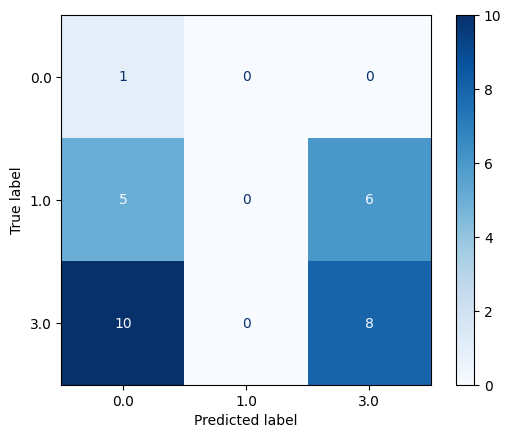

C:\Users\tschoppj\AppData\Local\Temp\ipykernel_40144\197826741.py:95: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


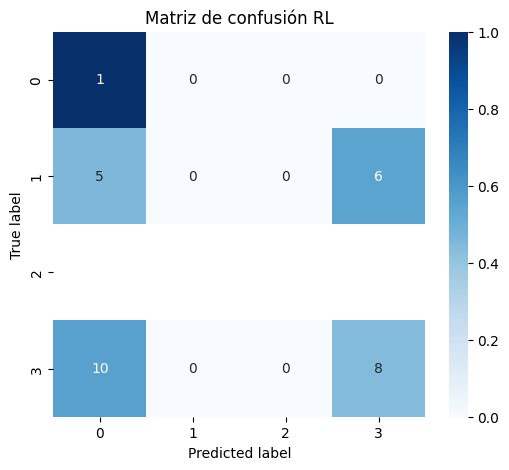

F1-score (macro): 0.2059


In [8]:
import seaborn as sns
# Lista de variables importantes
var_importance = ['Cianobac', 'MicrtEli', 'time_int', 'Ptot_lab', 'Clorof_A', 'NT', 'pHsupC', 'TurSupC', 'NH_lab', 'SS_105', 'NO3_lab', 'T_sup', 'ODsupC', 'CondsupC', 'PROFSITI', 'NO2_lab']
# Mejores hiperparámetros encontrados (reemplaza con tus resultados)
best_params_logreg = {
    'C': 0.001, 
    'penalty': 'l2', 
    'solver': 'saga', 
    'tol': 1e-3
}

# Ejecutar el test walk-forward con las variables seleccionadas
preds_logreg, trues_logreg, acc_logreg, cm_logreg = walkforward_test_logreg(
    df,
    best_params=best_params_logreg,
    target_col='target',
    time_col='time',
    test_start='2025-01-23',
    test_end='2025-02-21',
    var_importance=var_importance  # Pasar las variables importantes
)

# SVM

## Busqueda de hiperparametros con grid search SVM

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from itertools import product
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def walkforward_grid_search_svm(
    df, 
    target_col='target', 
    time_col='time', 
    val_start='2024-11-24', 
    val_end='2025-01-22', 
    param_grid=None,
    var_importance=[]  # Lista de variables importantes
):
    """
    Grid search de SVM con walk-forward sobre la ventana de validación.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame con los datos
    target_col : str
        Nombre de la columna objetivo
    time_col : str
        Nombre de la columna de tiempo
    val_start : str
        Fecha de inicio del período de validación
    val_end : str
        Fecha de fin del período de validación
    param_grid : dict
        Diccionario con los hiperparámetros a probar
    var_importance : list
        Lista de variables importantes a usar. Si está vacía, usa todas las variables.
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    if 'time_int' not in df.columns:
        base = pd.Timestamp('1900-01-01')
        df['time_int'] = (df[time_col] - base).dt.days + 1
    
    # Determinar las columnas de características a usar
    all_feature_cols = [col for col in df.columns if col not in [time_col, target_col, 'time_int']]
    
    # Si var_importance está vacía, usar todas las características
    if len(var_importance) == 0:
        feature_cols = all_feature_cols
    else:
        feature_cols = [col for col in var_importance if col in df.columns]
        if len(feature_cols) == 0:
            print("Advertencia: Ninguna de las variables importantes está en el DataFrame. Usando todas las variables.")
            feature_cols = all_feature_cols
    
    print(f"Entrenando con {len(feature_cols)} variables: {feature_cols}")
    
    val_days = pd.date_range(val_start, val_end)
    
    if param_grid is None:
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto', 0.1, 0.01],
            'class_weight': [None, 'balanced'],
            'tol': [1e-3, 1e-4]
        }
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]
    
    best_score = -1
    best_params = None
    all_results = []
    
    # DataFrame para almacenar la importancia de las características
    feature_importance_df = pd.DataFrame()
    
    print(f"Probando {len(param_combinations)} combinaciones de hiperparámetros...")
    for params in tqdm(param_combinations):
        preds = []
        trues = []
        
        for val_day in val_days:
            train_idx = df[time_col] < val_day
            val_idx = df[time_col] == val_day
            if val_idx.sum() == 0 or train_idx.sum() == 0:
                continue

            X_train = df.loc[train_idx, feature_cols]
            y_train = df.loc[train_idx, target_col].values.ravel()  # Asegura que sea 1D
            X_val = df.loc[val_idx, feature_cols]
            y_val = df.loc[val_idx, target_col].values.ravel()  # Asegura que sea 1D
            
            # Aplicar escalado (recomendado para SVM)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            try:
                clf = SVC(**params, random_state=42, probability=True)
                clf.fit(X_train_scaled, y_train)
                y_pred = clf.predict(X_val_scaled)
                preds.extend(y_pred)
                trues.extend(y_val)
                
                # Calcular importancia de características si es kernel lineal
                if params['kernel'] == 'linear':
                    # Para SVM lineal, los coeficientes son una medida de importancia
                    feature_importances = np.abs(clf.coef_[0]) if hasattr(clf, 'coef_') else None
                    
                    if feature_importances is not None:
                        # Crear un DataFrame temporal con las importancias
                        temp_df = pd.DataFrame({
                            'feature': feature_cols,
                            'importance': feature_importances,
                            'val_day': val_day
                        })
                        # Ordenar por importancia descendente
                        temp_df = temp_df.sort_values('importance', ascending=False).reset_index(drop=True)
                        # Añadir ranking
                        temp_df['rank'] = temp_df.index + 1
                        # Concatenar al DataFrame principal
                        feature_importance_df = pd.concat([feature_importance_df, temp_df], ignore_index=True)
                
            except Exception as e:
                print(f"Error con los parámetros {params}: {e}")
                continue
        
        if preds and trues:
            acc = accuracy_score(trues, preds)
            all_results.append({'params': params, 'accuracy': acc})
            if acc > best_score:
                best_score = acc
                best_params = params
    
    print("\nResultados del grid search:")
    for result in sorted(all_results, key=lambda x: x['accuracy'], reverse=True)[:10]:
        print(f"Parámetros: {result['params']}, Exactitud: {result['accuracy']:.4f}")
    
    print(f"\nMejores hiperparámetros: {best_params}")
    print(f"Exactitud en validación: {best_score:.4f}")
    
    # Visualizar la importancia promedio de las características si hay datos
    if not feature_importance_df.empty:
        avg_importance = feature_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        avg_importance.plot(kind='bar')
        plt.title('Importancia promedio de características en todas las iteraciones (SVM)')
        plt.ylabel('Importancia')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNota: No se pudo calcular la importancia de características porque no se usó kernel lineal o no hay suficientes datos.")
    
    return best_params, best_score, all_results, feature_importance_df

Entrenando con 7 variables: ['Cianobac', 'MicrtEli', 'time_int', 'Ptot_lab', 'Clorof_A', 'NT', 'pHsupC']
Probando 6 combinaciones de hiperparámetros...


100%|██████████| 6/6 [00:26<00:00,  4.45s/it]


Resultados del grid search:
Parámetros: {'C': 0.01, 'kernel': 'linear', 'gamma': 'scale', 'tol': 0.001}, Exactitud: 0.8667
Parámetros: {'C': 0.01, 'kernel': 'linear', 'gamma': 'auto', 'tol': 0.001}, Exactitud: 0.8667
Parámetros: {'C': 0.01, 'kernel': 'linear', 'gamma': 0.001, 'tol': 0.001}, Exactitud: 0.8667
Parámetros: {'C': 0.01, 'kernel': 'rbf', 'gamma': 'scale', 'tol': 0.001}, Exactitud: 0.8667
Parámetros: {'C': 0.01, 'kernel': 'rbf', 'gamma': 'auto', 'tol': 0.001}, Exactitud: 0.8667
Parámetros: {'C': 0.01, 'kernel': 'rbf', 'gamma': 0.001, 'tol': 0.001}, Exactitud: 0.8667

Mejores hiperparámetros: {'C': 0.01, 'kernel': 'linear', 'gamma': 'scale', 'tol': 0.001}
Exactitud en validación: 0.8667


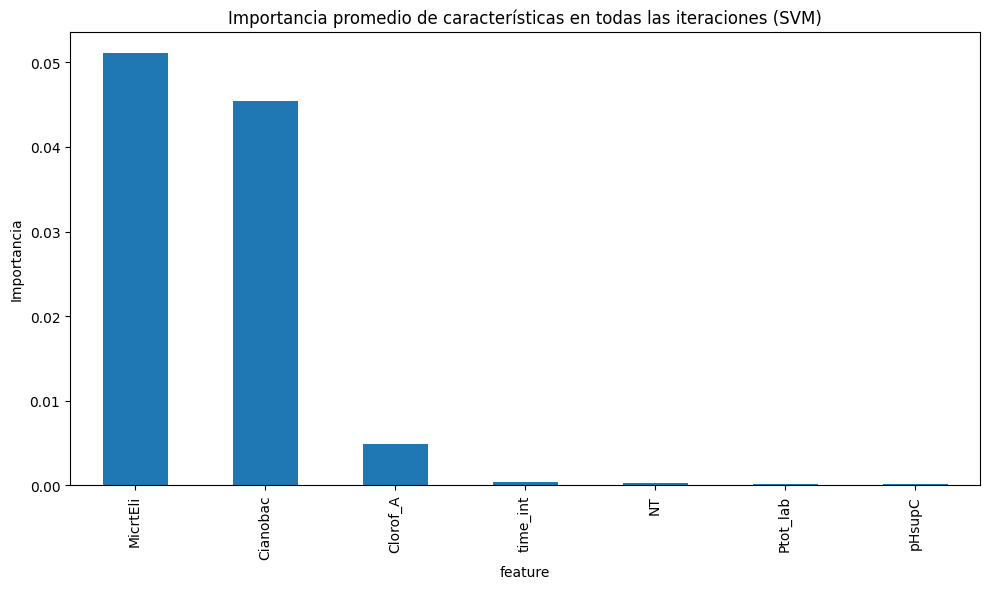

In [17]:
# Parámetros más reducidos para evitar tiempos de ejecución muy largos
param_grid = {
    'C': [0.01],
    'kernel': ['linear', 'rbf'],#
    'gamma': ['scale', 'auto', 0.001],
    'tol': [1e-3]
}

var_importance = ['Cianobac', 'MicrtEli', 'time_int', 'Ptot_lab', 'Clorof_A', 'NT', 'pHsupC']
best_params_svm, best_score_svm, all_results_svm, feature_importance_df_svm = walkforward_grid_search_svm(
    df=df_train_val, 
    var_importance=var_importance,
    param_grid=param_grid
)

Resultados del grid search:
Parámetros: {'C': 0.01, 'kernel': 'linear', 'gamma': 'scale', 'tol': 0.001}, Exactitud: 0.8667
Parámetros: {'C': 0.01, 'kernel': 'linear', 'gamma': 'auto', 'tol': 0.001}, Exactitud: 0.8667
Parámetros: {'C': 0.01, 'kernel': 'linear', 'gamma': 0.001, 'tol': 0.001}, Exactitud: 0.8667
Parámetros: {'C': 0.01, 'kernel': 'rbf', 'gamma': 'scale', 'tol': 0.001}, Exactitud: 0.8667
Parámetros: {'C': 0.01, 'kernel': 'rbf', 'gamma': 'auto', 'tol': 0.001}, Exactitud: 0.8667
Parámetros: {'C': 0.01, 'kernel': 'rbf', 'gamma': 0.001, 'tol': 0.001}, Exactitud: 0.8667

Mejores hiperparámetros: {'C': 0.01, 'kernel': 'linear', 'gamma': 'scale', 'tol': 0.001}
Exactitud en validación: 0.8667


## Test SVM

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from datetime import datetime

def walkforward_test_svm(
    df, 
    best_params, 
    target_col='target', 
    time_col='time', 
    test_start='2025-01-23', 
    test_end='2025-02-21',
    var_importance=[]  # Lista de variables importantes
):
    """
    Test walk-forward sobre la ventana de test usando los mejores hiperparámetros para SVM.
    Imprime exactitud y matriz de confusión.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame con los datos
    best_params : dict
        Mejores hiperparámetros encontrados para SVM
    target_col : str
        Nombre de la columna objetivo
    time_col : str
        Nombre de la columna de tiempo
    test_start : str
        Fecha de inicio del período de test
    test_end : str
        Fecha de fin del período de test
    var_importance : list
        Lista de variables importantes a usar. Si está vacía, usa todas las variables.
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    if 'time_int' not in df.columns:
        base = datetime(1900, 1, 1)
        df['time_int'] = (df[time_col] - base).dt.days + 1
    
    # Determinar las columnas de características a usar
    all_feature_cols = [col for col in df.columns if col not in [time_col, target_col, 'time_int']]
    
    # Si var_importance está vacía, usar todas las características
    if len(var_importance) == 0:
        feature_cols = all_feature_cols
    else:
        feature_cols = [col for col in var_importance if col in df.columns]
        if len(feature_cols) == 0:
            print("Advertencia: Ninguna de las variables importantes está en el DataFrame. Usando todas las variables.")
            feature_cols = all_feature_cols
    
    print(f"Evaluando con {len(feature_cols)} variables: {feature_cols}")
    
    test_days = pd.date_range(test_start, test_end)
    preds = []
    trues = []
    
    # Para almacenar la importancia de características si es kernel lineal
    feature_importance_df = pd.DataFrame()
    
    for test_day in tqdm(test_days, desc="Walk-forward test"):
        train_idx = df[time_col] < test_day
        test_idx = df[time_col] == test_day
        if test_idx.sum() == 0 or train_idx.sum() == 0:
            continue
        
        X_train = df.loc[train_idx, feature_cols]
        y_train = df.loc[train_idx, target_col].values.ravel()  # Asegura que sea 1D
        X_test = df.loc[test_idx, feature_cols]
        y_test = df.loc[test_idx, target_col].values.ravel()  # Asegura que sea 1D
        
        # Aplicar escalado (recomendado para SVM)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        clf = SVC(**best_params, random_state=42, probability=True)
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
        preds.extend(y_pred)
        trues.extend(y_test)
        
        # Calcular importancia de características si es kernel lineal
        if best_params.get('kernel') == 'linear' and hasattr(clf, 'coef_'):
            feature_importances = np.abs(clf.coef_[0])
            
            # Crear un DataFrame temporal con las importancias
            temp_df = pd.DataFrame({
                'feature': feature_cols,
                'importance': feature_importances,
                'test_day': test_day
            })
            # Ordenar por importancia descendente
            temp_df = temp_df.sort_values('importance', ascending=False).reset_index(drop=True)
            # Añadir ranking
            temp_df['rank'] = temp_df.index + 1
            # Concatenar al DataFrame principal
            feature_importance_df = pd.concat([feature_importance_df, temp_df], ignore_index=True)
    
    # Calcular métricas
    acc = accuracy_score(trues, preds)
    print(f"Exactitud en test: {acc:.4f}")
    
    # Determinar las etiquetas únicas para la matriz de confusión
    unique_labels = sorted(set(trues) | set(preds))
    
    cm = confusion_matrix(trues, preds, labels=unique_labels)
    print("Matriz de aciertos (confusión):")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    disp.plot(cmap="Blues")
    plt.show()
    
    labels = [0, 1, 2, 3]
    cm = confusion_matrix(trues, preds, labels=labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm_normalized, 
        annot=cm,            # <--- aquí pones los valores reales
        fmt='d',             # formato entero
        cmap="Blues", 
        xticklabels=labels, 
        yticklabels=labels,
        cbar=True
    )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Matriz de confusión SVM')
    plt.show()
    
    # Visualizar la importancia promedio de las características si hay datos
    if not feature_importance_df.empty:
        avg_importance = feature_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        avg_importance.plot(kind='bar')
        plt.title('Importancia promedio de características en test (SVM)')
        plt.ylabel('Importancia')
        plt.tight_layout()
        plt.show()
    
    return preds, trues, acc, cm, feature_importance_df

Evaluando con 7 variables: ['Cianobac', 'MicrtEli', 'time_int', 'Ptot_lab', 'Clorof_A', 'NT', 'pHsupC']


Walk-forward test: 100%|██████████| 30/30 [00:01<00:00, 18.25it/s]


Exactitud en test: 0.2000
Matriz de aciertos (confusión):
[[ 1  0  0]
 [ 6  0  5]
 [13  0  5]]


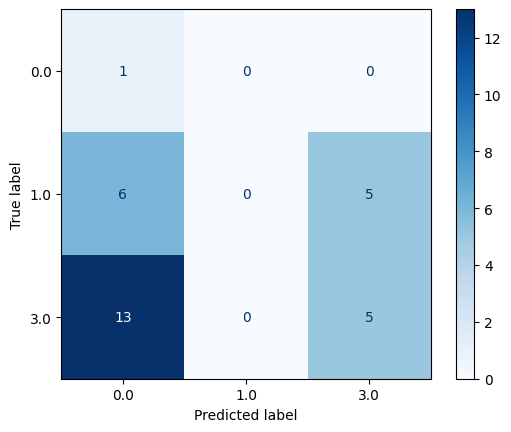

C:\Users\tschoppj\AppData\Local\Temp\ipykernel_40144\1483620481.py:121: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


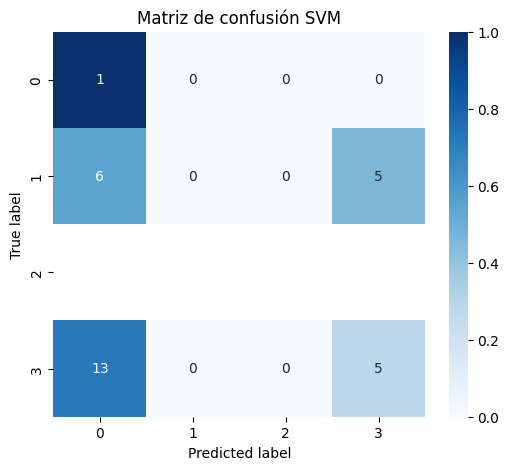

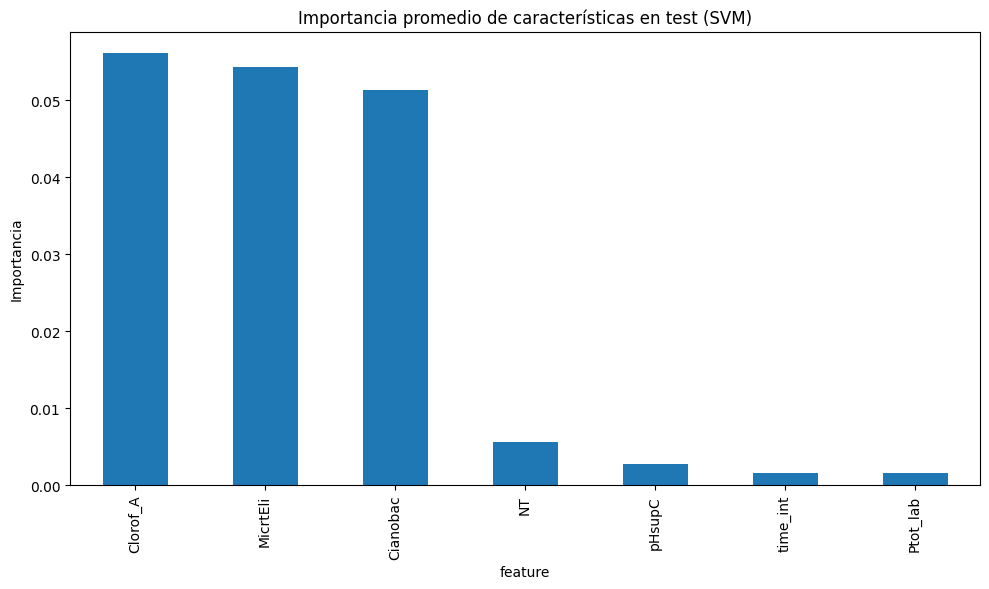

In [19]:
# Importar numpy si no está importado
import numpy as np

# Lista de variables importantes
var_importance = ['Cianobac', 'MicrtEli', 'time_int', 'Ptot_lab', 'Clorof_A', 'NT', 'pHsupC']

# Mejores hiperparámetros encontrados (reemplaza con tus resultados)
best_params_svm = {
    'C': 0.01, 
    'kernel': 'linear', 
    'gamma': 'scale', 
    'tol': 0.001}

# Ejecutar el test walk-forward
preds_svm, trues_svm, acc_svm, cm_svm, feature_importance_df_svm = walkforward_test_svm(
    df,
    best_params=best_params_svm,
    target_col='target',
    time_col='time',
    test_start='2025-01-23',
    test_end='2025-02-21',
    var_importance=var_importance
)

# LGBM

## Busqueda de hiperparametros LGBM

In [21]:
%pip install optuna lightgbm

  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 38.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 2.1/2.1 MB 39.3 MB/s eta 0:00:00
Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl (156 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import lightgbm as lgbm
from sklearn.metrics import accuracy_score
from itertools import product
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def walkforward_grid_search_lgbm(
    df, 
    target_col='target', 
    time_col='time', 
    val_start='2024-11-24', 
    val_end='2025-01-22', 
    param_grid=None
):
    """
    Grid search de LightGBM con walk-forward sobre la ventana de validación.
    Utiliza todos los atributos disponibles sin reducción de dimensionalidad.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame con los datos
    target_col : str
        Nombre de la columna objetivo
    time_col : str
        Nombre de la columna de tiempo
    val_start : str
        Fecha de inicio del período de validación
    val_end : str
        Fecha de fin del período de validación
    param_grid : dict
        Diccionario con los hiperparámetros a probar
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    if 'time_int' not in df.columns:
        base = pd.Timestamp('1900-01-01')
        df['time_int'] = (df[time_col] - base).dt.days + 1
    
    # Usar todas las características disponibles excepto las columnas de tiempo y objetivo
    feature_cols = [col for col in df.columns if col not in [time_col, target_col, 'time_int']]
    
    print(f"Entrenando con {len(feature_cols)} variables (todas las disponibles)")
    
    val_days = pd.date_range(val_start, val_end)
    
    if param_grid is None:
        param_grid = {
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'num_leaves': [31, 63, 127],
            'min_child_samples': [20, 50],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'reg_alpha': [0, 0.1],
            'reg_lambda': [0, 0.1]
        }
    
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]
    
    best_score = -1
    best_params = None
    all_results = []
    
    # DataFrame para almacenar la importancia de las características
    feature_importance_df = pd.DataFrame()
    
    print(f"Probando {len(param_combinations)} combinaciones de hiperparámetros...")
    for params in tqdm(param_combinations):
        preds = []
        trues = []
        
        for val_day in val_days:
            train_idx = df[time_col] < val_day
            val_idx = df[time_col] == val_day
            if val_idx.sum() == 0 or train_idx.sum() == 0:
                continue

            X_train = df.loc[train_idx, feature_cols]
            y_train = df.loc[train_idx, target_col].values.ravel()  # Asegura que sea 1D
            X_val = df.loc[val_idx, feature_cols]
            y_val = df.loc[val_idx, target_col].values.ravel()  # Asegura que sea 1D
            
            try:
                # Configurar el modelo LightGBM
                clf = lgbm.LGBMClassifier(
                    **params,
                    random_state=42,
                    objective='multiclass',  # Para clasificación multiclase
                    verbose=-1,  # Desactivar mensajes de progreso
                    n_jobs=-1    # Usar todos los núcleos disponibles
                )
                
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_val)
                preds.extend(y_pred)
                trues.extend(y_val)
                
                # Guardar importancia de características para este día
                importances = clf.feature_importances_
                
                # Crear un DataFrame temporal con las importancias
                temp_df = pd.DataFrame({
                    'feature': feature_cols,
                    'importance': importances,
                    'val_day': val_day
                })
                # Ordenar por importancia descendente
                temp_df = temp_df.sort_values('importance', ascending=False).reset_index(drop=True)
                # Añadir ranking
                temp_df['rank'] = temp_df.index + 1
                # Concatenar al DataFrame principal
                feature_importance_df = pd.concat([feature_importance_df, temp_df], ignore_index=True)
                
            except Exception as e:
                print(f"Error con los parámetros {params}: {e}")
                continue
        
        if preds and trues:
            acc = accuracy_score(trues, preds)
            all_results.append({'params': params, 'accuracy': acc})
            if acc > best_score:
                best_score = acc
                best_params = params
    
    print("\nResultados del grid search:")
    for result in sorted(all_results, key=lambda x: x['accuracy'], reverse=True)[:10]:
        print(f"Parámetros: {result['params']}, Exactitud: {result['accuracy']:.4f}")
    
    print(f"\nMejores hiperparámetros: {best_params}")
    print(f"Exactitud en validación: {best_score:.4f}")
    
    # Visualizar la importancia promedio de las características
    if not feature_importance_df.empty:
        avg_importance = feature_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False)
        
        # Mostrar las 20 características más importantes
        top_features = avg_importance.head(20)
        plt.figure(figsize=(12, 8))
        top_features.plot(kind='bar')
        plt.title('Top 20 características más importantes (LGBM)')
        plt.ylabel('Importancia')
        plt.tight_layout()
        plt.show()
        
        # Mostrar todas las características
        plt.figure(figsize=(14, 10))
        avg_importance.plot(kind='bar')
        plt.title('Importancia promedio de todas las características (LGBM)')
        plt.ylabel('Importancia')
        plt.tight_layout()
        plt.xticks(rotation=90)
        plt.show()
    
    return best_params, best_score, all_results, feature_importance_df

Entrenando con 56 variables (todas las disponibles)
Probando 16 combinaciones de hiperparámetros...


100%|██████████| 16/16 [15:14<00:00, 57.18s/it]



Resultados del grid search:
Parámetros: {'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 7, 'num_leaves': 31, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0, 'reg_lambda': 0}, Exactitud: 0.8000
Parámetros: {'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 7, 'num_leaves': 63, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0, 'reg_lambda': 0}, Exactitud: 0.7833
Parámetros: {'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 5, 'num_leaves': 31, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0, 'reg_lambda': 0}, Exactitud: 0.7667
Parámetros: {'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 5, 'num_leaves': 63, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0, 'reg_lambda': 0}, Exactitud: 0.7667
Parámetros: {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5, 'num_leaves': 31, 'min_child_samples': 20, 'subsample': 0.8

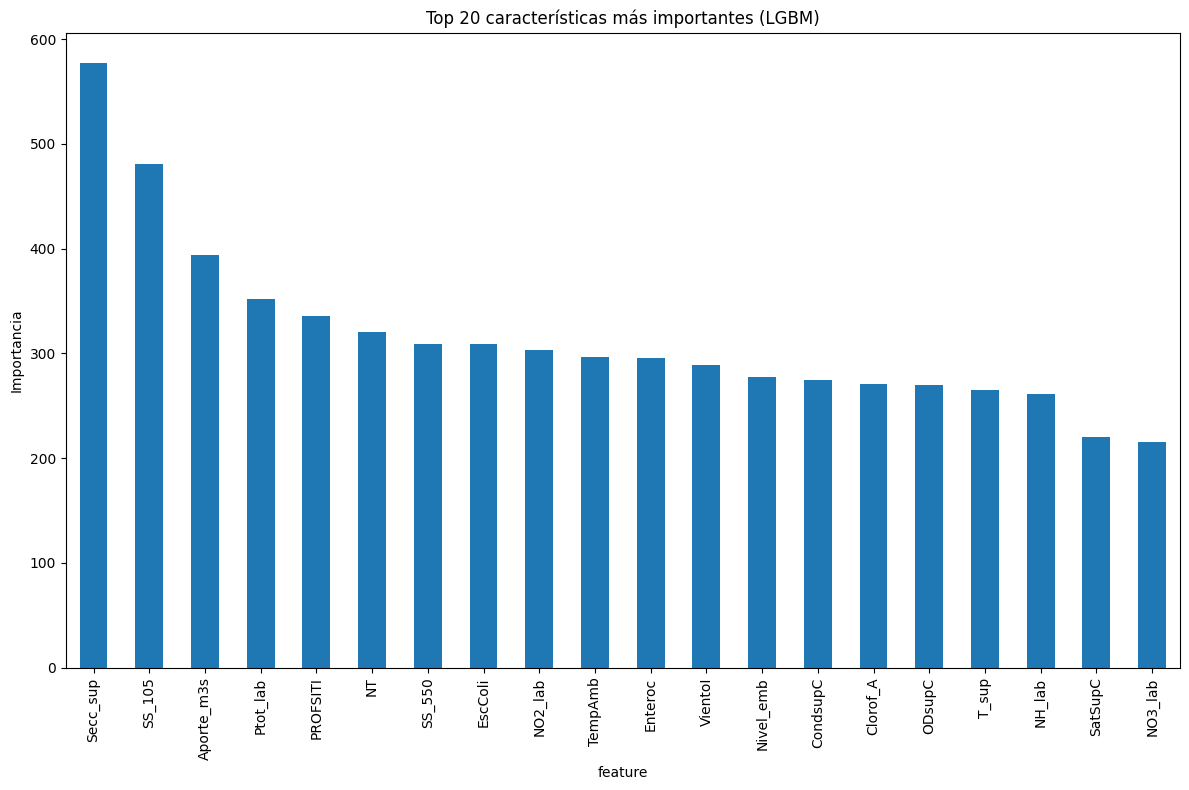

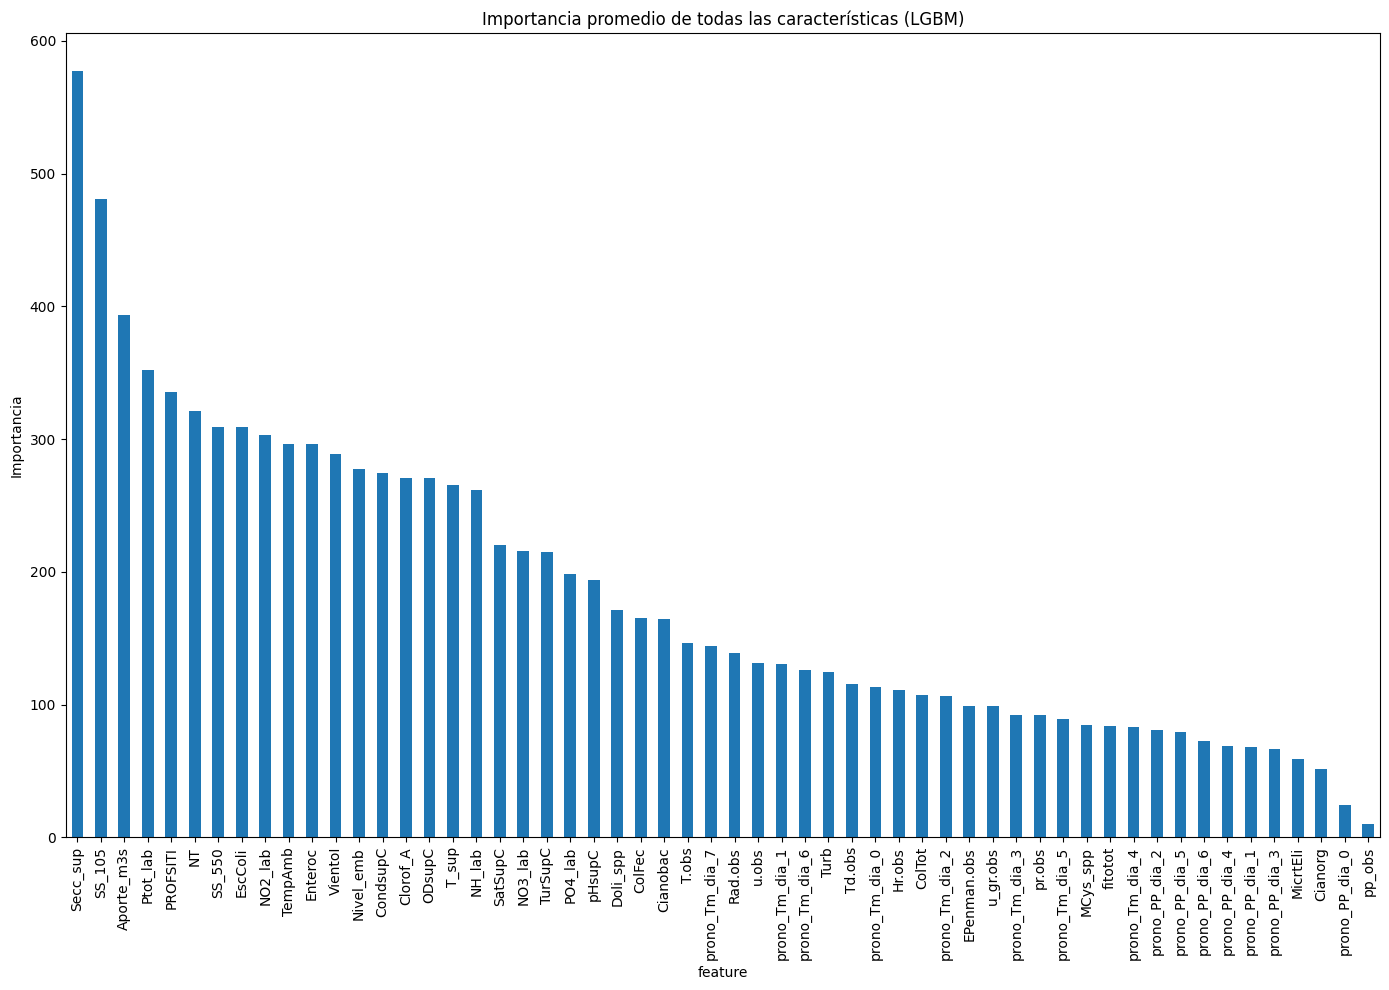

In [ ]:
# Asegúrate de tener lightgbm instalado
# !pip install lightgbm

# Definir un grid de parámetros más pequeño para reducir el tiempo de ejecución
param_grid_lgbm = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'num_leaves': [31, 63],
    'min_child_samples': [20],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0],
    'reg_lambda': [0]
}

# Ejecutar la búsqueda de hiperparámetros
best_params_lgbm, best_score_lgbm, all_results_lgbm, feature_importance_df_lgbm = walkforward_grid_search_lgbm(
    df=df_train_val,
    param_grid=param_grid_lgbm
)

# LGBM con Optuna

In [24]:
import lightgbm as lgbm
from sklearn.metrics import accuracy_score
import optuna
from tqdm import tqdm
import pandas as pd
import numpy as np
import tqdm as notebook_tqdm

def walkforward_optuna_lgbm(
    df, 
    target_col='target', 
    time_col='time', 
    val_start='2024-11-24', 
    val_end='2025-01-22',
    n_trials=50,  # Número de pruebas para Optuna
    timeout=600   # Tiempo límite en segundos (10 minutos)
):
    """
    Búsqueda de hiperparámetros con Optuna para LightGBM con walk-forward sobre la ventana de validación.
    Utiliza todos los atributos disponibles sin reducción de dimensionalidad.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame con los datos
    target_col : str
        Nombre de la columna objetivo
    time_col : str
        Nombre de la columna de tiempo
    val_start : str
        Fecha de inicio del período de validación
    val_end : str
        Fecha de fin del período de validación
    n_trials : int
        Número de pruebas para Optuna
    timeout : int
        Tiempo límite en segundos para la búsqueda
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    if 'time_int' not in df.columns:
        base = pd.Timestamp('1900-01-01')
        df['time_int'] = (df[time_col] - base).dt.days + 1
    
    # Usar todas las características disponibles excepto las columnas de tiempo y objetivo
    feature_cols = [col for col in df.columns if col not in [time_col, target_col, 'time_int']]
    
    print(f"Entrenando con {len(feature_cols)} variables (todas las disponibles)")
    
    val_days = pd.date_range(val_start, val_end)
    
    # Definir la función objetivo para Optuna
    def objective(trial):
        # Definir los hiperparámetros a optimizar
        params = {
            'objective': 'multiclass',
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'verbosity': -1,
            'n_jobs': -1,
            'random_state': 42,
            
            # Hiperparámetros a optimizar
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)
        }
        
        preds = []
        trues = []
        
        for val_day in val_days:
            train_idx = df[time_col] < val_day
            val_idx = df[time_col] == val_day
            if val_idx.sum() == 0 or train_idx.sum() == 0:
                continue

            X_train = df.loc[train_idx, feature_cols]
            y_train = df.loc[train_idx, target_col].values.ravel()
            X_val = df.loc[val_idx, feature_cols]
            y_val = df.loc[val_idx, target_col].values.ravel()
            
            try:
                clf = lgbm.LGBMClassifier(**params)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_val)
                preds.extend(y_pred)
                trues.extend(y_val)
            except Exception as e:
                print(f"Error con los parámetros {params}: {e}")
                return 0.0  # Retornar un valor bajo en caso de error
        
        if preds and trues:
            acc = accuracy_score(trues, preds)
            return acc
        else:
            return 0.0
    
    # Crear el estudio de Optuna
    study = optuna.create_study(direction='maximize')
    
    # Ejecutar la optimización
    print(f"Iniciando optimización con Optuna ({n_trials} pruebas, timeout: {timeout} segundos)...")
    study.optimize(objective, n_trials=n_trials, timeout=timeout)
    
    # Obtener los mejores parámetros
    best_params = study.best_params
    best_score = study.best_value
    
    # Añadir parámetros fijos a los mejores parámetros
    best_params_full = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
        'random_state': 42,
        **best_params
    }
    
    print("\nMejores hiperparámetros encontrados:")
    for param, value in best_params_full.items():
        print(f"{param}: {value}")
    print(f"\nExactitud en validación: {best_score:.4f}")
    
    return best_params_full

g:\Mi unidad\01-Maestria Ciencia de Datos\00-Tesis-I\PC_Work\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Ejecutar la búsqueda de hiperparámetros con Optuna
param_lgbm = walkforward_optuna_lgbm(
    df=df_train_val,
    n_trials=30,    # Reducido para que termine más rápido
    timeout=3000     # 5 minutos de tiempo límite
)

# param_lgbm ahora contiene los mejores hiperparámetros encontrados
print("Mejores parámetros para LGBM:")
print(param_lgbm)

[I 2025-06-11 19:59:45,458] A new study created in memory with name: no-name-79cf56b7-a2be-4c85-b99d-109cbf98e551


Entrenando con 49 variables (todas las disponibles)
Iniciando optimización con Optuna (30 pruebas, timeout: 3000 segundos)...


[I 2025-06-11 20:00:17,000] Trial 0 finished with value: 0.9 and parameters: {'learning_rate': 0.036634205329576904, 'n_estimators': 158, 'max_depth': 3, 'num_leaves': 118, 'min_child_samples': 30, 'subsample': 0.5975044436875705, 'colsample_bytree': 0.91261590931215, 'reg_alpha': 5.15735003383324e-06, 'reg_lambda': 1.54806045434233e-06}. Best is trial 0 with value: 0.9.
[I 2025-06-11 20:01:29,372] Trial 1 finished with value: 0.9166666666666666 and parameters: {'learning_rate': 0.020539429317791912, 'n_estimators': 282, 'max_depth': 4, 'num_leaves': 30, 'min_child_samples': 20, 'subsample': 0.8909130167263258, 'colsample_bytree': 0.6126138604758464, 'reg_alpha': 0.0012512025854959595, 'reg_lambda': 1.972554273713487e-08}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-06-11 20:01:56,179] Trial 2 finished with value: 0.9333333333333333 and parameters: {'learning_rate': 0.044479906059592955, 'n_estimators': 118, 'max_depth': 7, 'num_leaves': 64, 'min_child_samples': 67, 'subsam


Mejores hiperparámetros encontrados:
objective: multiclass
metric: multi_logloss
boosting_type: gbdt
verbosity: -1
n_jobs: -1
random_state: 42
learning_rate: 0.044479906059592955
n_estimators: 118
max_depth: 7
num_leaves: 64
min_child_samples: 67
subsample: 0.6706387828675462
colsample_bytree: 0.6073970046153572
reg_alpha: 0.0007177861036680376
reg_lambda: 0.00032355318074816684

Exactitud en validación: 0.9333
Mejores parámetros para LGBM:
{'objective': 'multiclass', 'metric': 'multi_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'n_jobs': -1, 'random_state': 42, 'learning_rate': 0.044479906059592955, 'n_estimators': 118, 'max_depth': 7, 'num_leaves': 64, 'min_child_samples': 67, 'subsample': 0.6706387828675462, 'colsample_bytree': 0.6073970046153572, 'reg_alpha': 0.0007177861036680376, 'reg_lambda': 0.00032355318074816684}


# Test LGBM

Mejores hiperparámetros encontrados:
objective: multiclass
metric: multi_logloss
boosting_type: gbdt
verbosity: -1
n_jobs: -1
random_state: 42
learning_rate: 0.2974885644403816
n_estimators: 229
max_depth: 9
num_leaves: 33
min_child_samples: 50
subsample: 0.9111102932824131
colsample_bytree: 0.5653123178202933
reg_alpha: 0.000988746421435559
reg_lambda: 0.0033973728692285026

Exactitud en validación: 0.9333
Mejores parámetros para LGBM:
{'objective': 'multiclass', 'metric': 'multi_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'n_jobs': -1, 'random_state': 42, 'learning_rate': 0.044479906059592955, 'n_estimators': 118, 'max_depth': 7, 'num_leaves': 64, 'min_child_samples': 67, 'subsample': 0.6706387828675462, 'colsample_bytree': 0.6073970046153572, 'reg_alpha': 0.0007177861036680376, 'reg_lambda': 0.00032355318074816684}

In [ ]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [25]:
import lightgbm as lgbm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns 

def walkforward_test_lgbm(
    df,
    best_params,
    target_col='target',
    time_col='time',
    test_start='2025-01-23',
    test_end='2025-02-21',
    var_importance=[]
):
    """
    Test walk-forward con LightGBM usando mejores hiperparámetros.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame con los datos
    best_params : dict
        Mejores hiperparámetros para LGBM
    target_col : str
        Nombre de la columna objetivo
    time_col : str
        Nombre de la columna de tiempo
    test_start : str
        Fecha de inicio del período de test
    test_end : str
        Fecha de fin del período de test
    var_importance : list
        Lista de variables importantes. Si está vacía, se usan todas.
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    if 'time_int' not in df.columns:
        base = datetime(1900, 1, 1)
        df['time_int'] = (df[time_col] - base).dt.days + 1

    all_feature_cols = [col for col in df.columns if col not in [time_col, target_col, 'time_int']]

    if not var_importance:
        feature_cols = all_feature_cols
    else:
        feature_cols = [col for col in var_importance if col in df.columns]
        if not feature_cols:
            print("Advertencia: ninguna variable importante encontrada, usando todas.")
            feature_cols = all_feature_cols

    print(f"Evaluando con {len(feature_cols)} variables: {feature_cols}")

    test_days = pd.date_range(test_start, test_end)
    preds, trues = [], []
    feature_importance_df = pd.DataFrame()

    for test_day in tqdm(test_days, desc="Walk-forward test"):
        train_idx = df[time_col] < test_day
        test_idx = df[time_col] == test_day
        if test_idx.sum() == 0 or train_idx.sum() == 0:
            continue

        X_train = df.loc[train_idx, feature_cols]
        y_train = df.loc[train_idx, target_col].values.ravel()
        X_test = df.loc[test_idx, feature_cols]
        y_test = df.loc[test_idx, target_col].values.ravel()

        clf = lgbm.LGBMClassifier(**best_params)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        preds.extend(y_pred)
        trues.extend(y_test)

        # Importancia de características
        importance = clf.feature_importances_
        temp_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': importance,
            'test_day': test_day
        })
        temp_df = temp_df.sort_values('importance', ascending=False).reset_index(drop=True)
        temp_df['rank'] = temp_df.index + 1
        feature_importance_df = pd.concat([feature_importance_df, temp_df], ignore_index=True)

    acc = accuracy_score(trues, preds)
    print(f"Exactitud en test: {acc:.4f}")

    unique_labels = sorted(set(trues) | set(preds))
    cm = confusion_matrix(trues, preds, labels=unique_labels)
    print("Matriz de confusión:")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    disp.plot(cmap="Blues")
    plt.show()
    
    labels = [0, 1, 2, 3]
    cm = confusion_matrix(trues, preds, labels=labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm_normalized, 
        annot=cm,            # <--- aquí pones los valores reales
        fmt='d',             # formato entero
        cmap="Blues", 
        xticklabels=labels, 
        yticklabels=labels,
        cbar=True
    )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Matriz de confusión LGBM')
    plt.show()

    if not feature_importance_df.empty:
        avg_importance = feature_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        avg_importance.plot(kind='bar')
        plt.title('Importancia promedio de características en test (LGBM)')
        plt.ylabel('Importancia')
        plt.tight_layout()
        plt.show()

    return preds, trues, acc, cm, feature_importance_df


Evaluando con 49 variables: ['T.obs', 'Hr.obs', 'pr.obs', 'Rad.obs', 'u.obs', 'u_gr.obs', 'Td.obs', 'EPenman.obs', 'pp_obs', 'prono_PP_dia_0', 'prono_PP_dia_1', 'prono_PP_dia_2', 'prono_PP_dia_3', 'prono_PP_dia_4', 'prono_PP_dia_5', 'prono_PP_dia_6', 'prono_Tm_dia_0', 'prono_Tm_dia_1', 'prono_Tm_dia_2', 'prono_Tm_dia_3', 'prono_Tm_dia_4', 'prono_Tm_dia_5', 'prono_Tm_dia_6', 'prono_Tm_dia_7', 'Aporte_m3s', 'Nivel_emb', 'NO3_lab', 'SS_105', 'NO2_lab', 'ODsupC', 'TempAmb', 'TurSupC', 'PO4_lab', 'SS_550', 'NT', 'NH_lab', 'Enteroc', 'Ptot_lab', 'Cianobac', 'Clorof_A', 'VientoI', 'T_sup', 'CondsupC', 'MicrtEli', 'EscColi', 'PROFSITI', 'SatSupC', 'pHsupC', 'Secc_sup']


Walk-forward test: 100%|██████████| 30/30 [00:15<00:00,  1.89it/s]

Exactitud en test: 0.9000
Matriz de confusión:
[[ 1  0  0]
 [ 0  9  2]
 [ 1  0 17]]


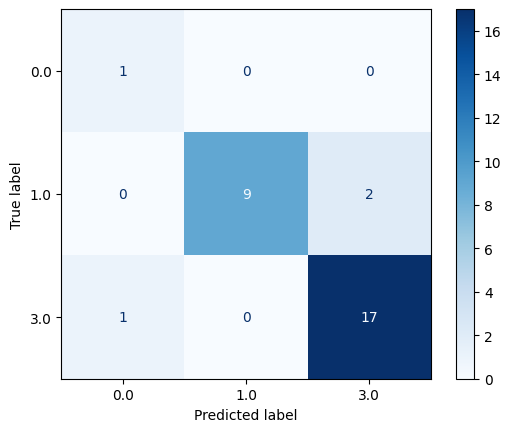

C:\Users\tschoppj\AppData\Local\Temp\ipykernel_40144\3973335289.py:103: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


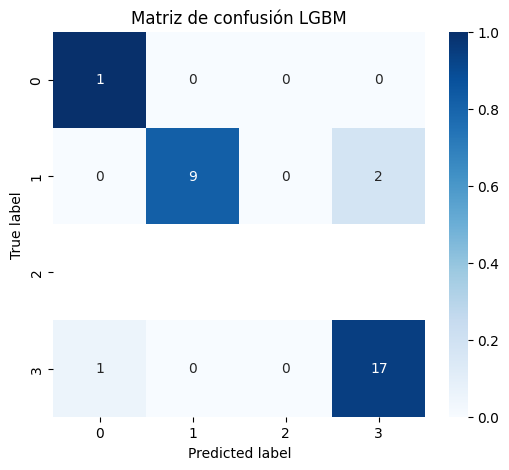

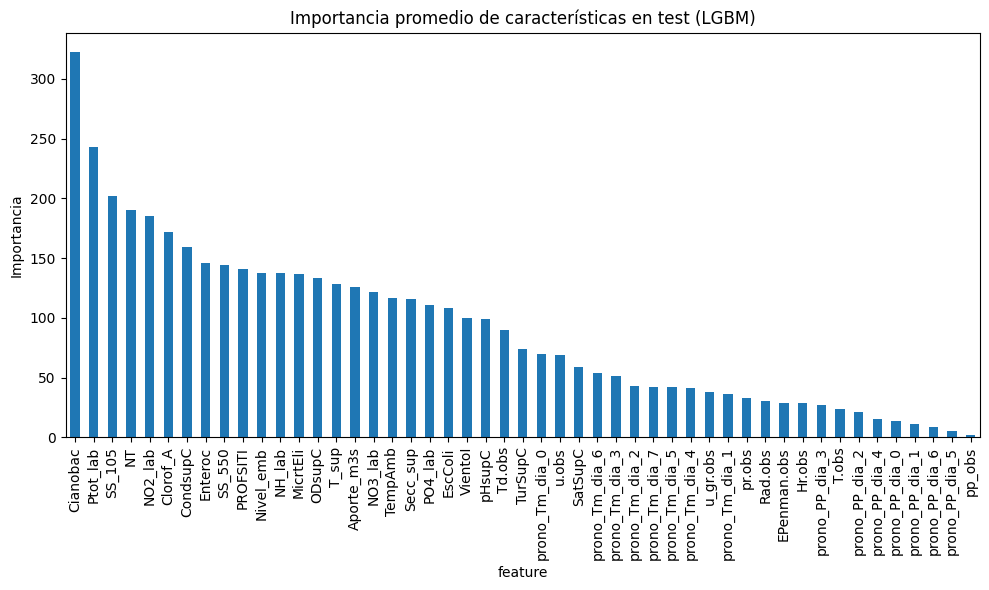

In [26]:

best_params_lgbm = {'objective': 'multiclass', 'metric': 'multi_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'n_jobs': -1, 'random_state': 42, 'learning_rate': 0.044479906059592955, 'n_estimators': 118, 'max_depth': 7, 'num_leaves': 64, 'min_child_samples': 67, 'subsample': 0.6706387828675462, 'colsample_bytree': 0.6073970046153572, 'reg_alpha': 0.0007177861036680376, 'reg_lambda': 0.00032355318074816684}
# Ejecutar el test walk-forward con LightGBM
preds_lgbm, trues_lgbm, acc_lgbm, cm_lgbm, feature_importance_df_lgbm = walkforward_test_lgbm(
    df,
    best_params=best_params_lgbm,
    target_col='target',
    time_col='time',
    test_start='2025-01-23',
    test_end='2025-02-21'
)
